# Data Exploration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Load the riz training data:

In [2]:
from tomo_challenge import load_data, load_redshift

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


In [3]:
bands='riz'
include_colors=False
include_errors=False

In [99]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


In [134]:
def prepare(band='i', nmax=None, shuffle=False, seed=123):
    n = min(nmax or len(train_data), len(train_data))
    colors = np.diff(train_data, axis=1)
    i = bands.index(band)
    if shuffle:
        gen = np.random.RandomState(seed)
        idx = gen.choice(len(train_data), n, replace=False)
    else:
        idx = slice(None)
    return np.concatenate((colors[idx], train_data[idx, i:i + 1]), axis=1), train_z[idx]

In [135]:
X, z = prepare()

In [108]:
import jax_cosmo.parameters
import jax_cosmo.background

In [129]:
def get_zedges(z, nzbin, plot=False):
    z = np.asarray(z)
    # Tabulate comoving distance over a grid spanning the full range of input redshifts.
    zgrid = np.linspace(0, z.max(), 1000)
    agrid = 1 / (1 + zgrid)
    model = jax_cosmo.parameters.Planck15()
    chi_grid = jax_cosmo.background.radial_comoving_distance(model, agrid)
    # Compute bin edges that are equally spaced in chi.
    chi_edges = np.linspace(0, chi_grid[-1], nzbin + 1)
    zedges = np.empty(nzbin + 1)
    zedges[0] = 0.
    zedges[-1] = z.max()
    zedges[1:-1] = np.interp(chi_edges[1:-1], chi_grid, zgrid)
    aedges = 1 / (1 + zedges)
    if plot:
        plots = {
            'Redshift $z$': z,
            'Scale factor $a$': 1 / (1 + z),
            'Comoving distance $\chi$ [Mpc]': np.interp(z, zgrid, chi_grid)
        }
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        for ax, label in zip(axes, plots):
            ax.hist(plots[label], bins=2 * nzbin, histtype='stepfilled', color='r', alpha=0.5)
            ax.set_xlabel(label)
        for ax, edges in zip(axes, (zedges, aedges, chi_edges)):
            ax.set_yticks([])
            ax.set_xlim(edges[0], edges[-1])
            for edge in edges[1:-1]:
                ax.axvline(edge, c='k', lw=1, alpha=0.5)
        plt.tight_layout()
    return zedges
    
zedges = get_zedges(train_z, 120)

In [147]:
def plotfbins(features, redshift, npct=20, nhist=100, inset_pct=1, show_edges=True):
    ndata, nfeat = features.shape
    assert redshift.shape == (ndata,)
    D = np.concatenate((features, redshift.reshape(-1, 1)), axis=1).T
    
    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    edges = np.percentile(D, pct, axis=1).T

    # Calculate inset ranges for histograms.
    ranges = np.percentile(D, (inset_pct, 100 - inset_pct), axis=1).T
    
    fig, axes = plt.subplots(nfeat + 1, nfeat + 1, figsize=(12, 12))
    for i in range(nfeat + 1):
        ax = axes[i, i]
        ax.hist(D[i], nhist, range=ranges[i])
        ax.set_xlim(*ranges[i])
        ax.set_yticks([])
        if show_edges:
            for edge in edges[i]:
                ax.axvline(edge, c='r', alpha=0.5, lw=1)
        for j in range(i + 1, nfeat + 1):
            ax = axes[j, i]
            hist, _, _ = np.histogram2d(D[i], D[j], [edges[i], edges[j]])
            ax.imshow(hist, origin='lower', interpolation='none', extent=[0, 100, 0, 100])
            ax = axes[i, j]
            ax.hist2d(D[j], D[i], nhist, range=(ranges[j], ranges[i]))
            if show_edges:
                for edge in edges[j]:
                    ax.axvline(edge, c='r', alpha=0.5, lw=1)
                for edge in edges[i]:
                    ax.axhline(edge, c='r', alpha=0.5, lw=1)
    plt.tight_layout()

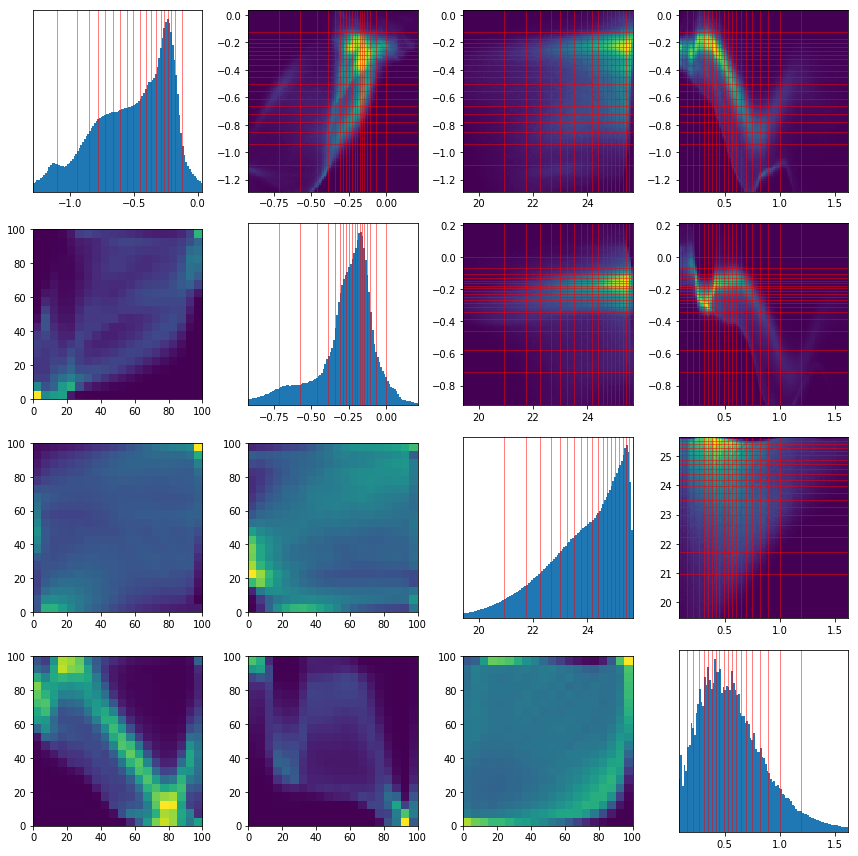

In [148]:
plotfbins(X, z)

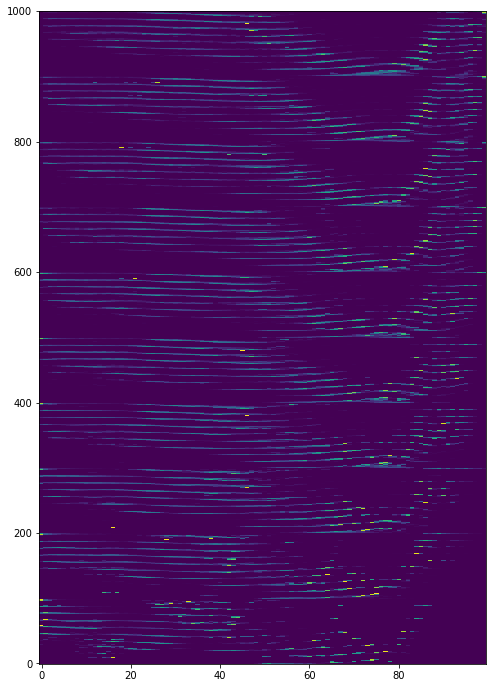

In [117]:
def plotzvecs(features, redshift, zedges, npct=20, pnorm=2):
    
    ndata, nfeat = features.shape
    D = features.T

    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    edges = np.percentile(D, pct, axis=1).T
    
    # Assign each sample to a 3D bin.
    mul = 1
    idx = np.zeros(ndata, int)
    for i in range(nfeat):
        idx += mul * np.clip(np.digitize(D[i], edges[i]) - 1, 0, npct - 1)
        mul *= npct
    n3d = npct ** nfeat
        
    # Histogram the redshift distribution in each 3D bin.
    nzbin = 
    zhist = np.empty((n3d, nzbin))
    zedges = np.percentile(redshift, np.linspace(0, 100, nzbin + 1))
    for i in range(n3d):
        zhist[i], _ = np.histogram(redshift[idx == i], zedges)
    
    znorm = np.sum(zhist ** pnorm, axis=1, keepdims=True) ** (1 / pnorm)
    zhist = np.divide(zhist, znorm, where=znorm > 0, out=zhist)
    
    fig = plt.figure(figsize=(8, 12))
    q = slice(None)
    #q = np.argsort(zhist[:, nzbin // 2])
    plt.imshow(zhist[q], aspect='auto', origin='lower')
    
plotzvecs(X, y)

In [35]:
def pairs_iterator(grpid, active):
    """Iterate over pairs of groups and perform some validations.
    """
    ids = np.unique(grpid)
    for i, id1 in enumerate(ids):
        sel1 = grpid == id1
        idx1 = np.where(sel1)[0]
        assert np.all(grpid[idx1] == np.min(idx1))
        if not np.any(active[sel1]):
            continue
        # Only the first bin in each group must be active.
        assert active[idx1[0]] and not np.any(active[idx1[1:]])
        for id2 in ids[i + 1:]:
            sel2 = grpid == id2
            idx2 = np.where(sel2)[0]
            assert np.all(grpid[idx2] == np.min(idx2))
            if not np.any(active[sel2]):
                continue
            # Only the first bin in each group must be active.
            assert active[idx2[0]] and not np.any(active[idx2[1:]])
            # Groups must be disjoint.
            assert not np.any(sel1 & sel2)
            yield idx1, idx2

In [36]:
def feature_similarity(dr2, grpid, active):
    """Calculate the feature similarity matrix from scratch.
    This is relatively slow so only used to validate faster incremental updates.
    """
    fsim = np.zeros_like(dr2)
    for idx1, idx2 in pairs_iterator(grpid, active):
        # Find the minimum separation between bins in these groups.
        dr2sub = dr2[np.ix_(idx1, idx2)]
        dr2min = np.min(dr2sub)
        # Save the result.
        gnorm = np.exp(-dr2min)
        fsim[idx1[0], idx2[0]] = gnorm
        fsim[idx2[0], idx1[0]] = gnorm
    # The similarities of inactive rows and columns should already be zero.
    assert np.all(fsim[~active, :] == 0)
    assert np.all(fsim[:, ~active] == 0)
    return fsim

In [37]:
def redshift_similarity(zhist, znorm, grpid, active, weighted):
    """Calculate the redshift similarity matrix from scratch.
    This is relatively slow so only used to validate faster incremental updates.
    """
    nfbin, nzbin = zhist.shape
    zsim = np.zeros((nfbin, nfbin))
    for idx1, idx2 in pairs_iterator(grpid, active):
        idx1 = idx1[0]
        idx2 = idx2[0]
        assert znorm[idx1] > 0 and znorm[idx2] > 0
        if weighted:
            z12norm = np.sqrt(np.sum((zhist[idx1] + zhist[idx2]) ** 2))
            z12sim = z12norm / (znorm[idx1] + znorm[idx2])
        else:
            z12dot = np.sum(zhist[idx1] * zhist[idx2])
            z12sim = z12dot / (znorm[idx1] * znorm[idx2])
        zsim[idx1, idx2] = z12sim
        zsim[idx2, idx1] = z12sim
    # The similarities of inactive rows and columns should already be zero.
    assert np.all(zsim[~active, :] == 0)
    assert np.all(zsim[:, ~active] == 0)
    return zsim

In [10]:
def validated(M1, M2):
    """Test if M1 and M2 are the same matrix"""
    assert M1.shape == M2.shape
    if np.allclose(M1, M2):
        return True
    else:
        diff = np.abs(M1 - M2)
        i, j = np.unravel_index(np.argmax(diff), M1.shape)
        print(f'max diff at [{i},{j}]: |{M1[i,j]}-{M2[i,j]}| = {diff[i,j]}')
        return False

In [ ]:
def groupinit(features, redshift, zedges, npct=20):
    """
    """
    ndata, nfeat = features.shape
    assert redshift.shape == (ndata,)
    D = features.T
    nzbin = len(zedges) - 1
    nfbin = int(npct ** nfeat)

    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    fedges = np.percentile(D, pct, axis=1).T
    
    # Assign each sample to a feature bin.
    mul = 1
    sample_bin = np.zeros(ndata, int)
    for i in range(nfeat):
        sample_bin += mul * np.clip(np.digitize(D[i], fedges[i]) - 1, 0, npct - 1)
        mul *= npct

    # Histogram the redshift distribution in each feature bin.
    zhist = np.empty((nfbin, nzbin), int)
    for i in range(nfbin):
        zhist[i], _ = np.histogram(redshift[sample_bin == i], zedges)
    
    return sample_bin, zhist

In [97]:
def groupbins(features, redshift, zedges, npct=10, weighted=True,
              sigma=0.2, min_groups=50, maxfrac=0.05, minfrac=0.001,
              validate=False, validate_interval=1000, maxiter=None):
    """Group similar bins in multidimensional feature space.
    
    Initial bins are defined as a rectangular grid in feature space with a grid
    defined such that the projections onto each feature axis contain an equal
    number of samples.  Any bins that contain no galaxies form one group and
    are removed from subsequent analysis.
        
    Similarity is defined as the product of independent feature and redshift similarities,
    with values in the range 0-1 and 1 indicating maximum similarity.
    
    Feature similarity is defined as exp(-(dr / sigma) ** 2) where dr is the Euclidean
    (grid index) separation in the multimensional feature space rectangular grid.
    The hyperparameter sigma controls the relative importance of the feature and
    redshift similarities in the subsequent grouping. Values of dr are normalized
    such that dr=1 corresonds to the full range of each feature, i.e., the grid
    size along each feature axis.
    
    Redshift similarity is based on the histogram of redshifts associated with each
    feature bin, interpreted as a vector.  When weighted is False, similarity is
    calculated as the cosine of the angle between two vectors.  Since all components
    of the redshift vector are histogram bin contents >= 0, the resulting cosine
    simililarities are all in the range 0-1
    
    Since cosine similarity uses normalized vectors, it does not give more weight to
    a feature bin containing more samples.  An alternative, when weighted is True,
    is to use a similarity score of |z1 + z2| / (|z1| + |z2|), which is equivalent
    to a weighted average of the cosine similarities between z1+z2 and z1 or z2,
    respectively, with weights wk = |zk| / (|z1| + |z2|).
    
    Feature bins are grouped iteratively, by combining the pair of groups with the
    maximum similiarity, until either a minimum number of groups is reached or else
    all remaining groups are above a minimum sample threshold.  There is also a
    maximum sample threshold, and pairs whose combination would exceed this
    threshold are never combined.
    
    For testing purposes, grouping can also be terminated after a fixed number
    of iterations.  The incremental updates of the feature and redshift similarity
    matrices can also be periodically validated against much slower calculations
    from scratch.
    
    When two groups are merged, their redshift histograms are added to calculate
    updated feature similarities with all other remaining groups.  The updated
    feature similarities use the minimum separation dr between the bins of
    the merged group and bins of each other group. This ensures that the maximum
    feature similarity occurs between adjacent groups, regardless of their size.
    """
    ndata, nfeat = features.shape
    assert redshift.shape == (ndata,)
    D = features.T
    nmax = int(np.round(maxfrac * ndata))
    nmin = int(np.round(minfrac * ndata))
    assert nmax > nmin
    nzbin = len(zedges) - 1
    nfbin = int(npct ** nfeat)
    print(f'Grouping with ndata={ndata}, nmin={nmin}, nmax={nmax}, nzbin={nzbin}, nfbin={nfbin}.')

    # Calculate percentile bins for each feature.
    pct = np.linspace(0, 100, npct + 1)
    fedges = np.percentile(D, pct, axis=1).T
    
    # Assign each sample to a feature bin.
    mul = 1
    sample_bin = np.zeros(ndata, int)
    for i in range(nfeat):
        sample_bin += mul * np.clip(np.digitize(D[i], fedges[i]) - 1, 0, npct - 1)
        mul *= npct

    # Histogram the redshift distribution in each feature bin.
    zhist = np.empty((nfbin, nzbin), int)
    for i in range(nfbin):
        zhist[i], _ = np.histogram(redshift[sample_bin == i], zedges)
    if validate:
        zhist0 = zhist.copy()
    
    # Calculate the number of samples (1-norm) in each feature bin.
    zsum = np.sum(zhist, axis=1)
    
    # Calculate the Euclidean 2-norm of the redshift vector for each feature bin.
    znorm = np.sqrt(np.sum(zhist ** 2, axis=1))
    
    # Assign initial group ids.
    grpid = np.arange(nfbin, dtype=int)
    active = np.ones(nfbin, bool)
    if np.any(znorm == 0):
        # Group all empty bins and mark them inactive.
        empty = zsum == 0
        active[empty] = False
        iempty = np.min(grpid[empty])
        grpid[empty] = iempty
    else:
        iempty = None
    ngrp = np.count_nonzero(active)
    
    # Initialize masks to zero elements on the diagonal or also below.
    nondiag = 1 - np.identity(nfbin)
    upper = np.triu(np.ones((nfbin, nfbin)), 1)
    
    # Calculate the normalized Euclidean distance matrix between feature bins.
    x = np.arange(npct) / (npct - 1)
    dims = np.meshgrid(*([x] * nfeat), sparse=False, copy=False)
    r1 = np.stack(dims, axis=-1).reshape(-1, nfeat)
    r2 = r1.reshape(-1, 1,  nfeat)
    dr2 = np.sum((r1 - r2) ** 2, axis=-1) / sigma ** 2
    assert dr2.shape == (nfbin, nfbin)
    
    # Calculate the initial feature similarity matrix.
    # Bins that are sufficiently far apart (relative to sigma) will
    # have fsim == 0, due to numerical precision, and will therefore
    # never be grouped.
    fsim = np.exp(-dr2)

    # Calculate the initial redshift similarity matrix.
    if weighted:
        pairs = zhist.reshape(nfbin, 1, nzbin) + zhist
        pairnorm = np.sqrt(np.sum(pairs ** 2, axis=-1))
        sumnorm = znorm.reshape(nfbin, 1) + znorm
        zsim = np.divide(pairnorm, sumnorm, where=sumnorm > 0, out=np.zeros_like(sumnorm))
    else:
        unit = np.divide(zhist, znorm.reshape(-1, 1), where=znorm.reshape(-1, 1) > 0, out=np.zeros_like(zhist, float))
        zsim = np.einsum('ij,kj->ik', unit, unit)

    if np.any(~active):
        inactive = np.where(~active)[0]
        fsim[inactive, :] = fsim[:, inactive] = 0.
        zsim[inactive, :] = zsim[:, inactive] = 0.
    fsim *= nondiag
    zsim *= nondiag
    
    # Initialize a mask of pairs that should not be grouped because that would exceed maxfrac.
    # Only elements above the diagonal will be used.
    eligible = np.ones((nfbin, nfbin))

    # Run iterative grouping.
    niter = 0
    while (ngrp > min_groups) and (np.min(zsum[active]) < nmin):
        # Find the pair of bins that are most similar.
        similarity = fsim * zsim * upper * eligible
        i1, i2 = np.unravel_index(np.argmax(similarity), similarity.shape)
        ##print(ngrp, i1, i2, zsim[i1, i2], fsim[i1, i2])
        assert i1 < i2
        assert active[i1] and active[i2]
        assert grpid[i1] == i1 and grpid[i2] == i2
        assert np.sum(zhist[active]) == ndata
        # Are we still below the threshold if we combine i1 and i2?
        if zsum[i1] + zsum[i2] <= nmax:
            # Merge i1 and i2 into i1.
            active[i2] = False
            sel1 = (grpid == i1)
            sel2 = (grpid == i2)
            ##print(np.where(sel1)[0], np.where(sel2)[0])
            grpid[sel1] = i1
            grpid[sel2] = i1
            # Update array values associated with i1.
            zhist[i1] += zhist[i2]
            oldi1znorm = znorm[i1]
            znorm[i1] = np.sqrt(np.sum(zhist[i1] ** 2))
            zsum[i1] += zsum[i2]
            # Calculate the redshift similarity of the merged (i1,i2) with all other bins.
            if weighted:
                pairs[i1, :] += zhist[i2]
                pairs[:, i1] += zhist[i2]
                i1pairnorm = np.sqrt(np.sum(pairs[i1] ** 2, axis=1))
                i1sumnorm = znorm + znorm[i1]
                newzsim = i1pairnorm / i1sumnorm
            else:
                unit[i1] = zhist[i1] / znorm[i1]
                newzsim = unit.dot(unit[i1])
            newzsim[i1] = 0.
            newzsim[~active] = 0.
            # Update the full redshift similarity matrix.
            zsim[i1, :] = zsim[:, i1] = newzsim
            zsim[i2, :] = zsim[:, i2] = 0.
            # Calculate the feature similarity of the merged (i1,i2) with all other bins.
            newfsim = np.maximum(fsim[i1], fsim[i2])
            newfsim[i1] = 0.
            newfsim[~active] = 0.
            # Update the full feature similarity matrix.
            fsim[i1, :] = fsim[:, i1] = newfsim
            fsim[i2, :] = fsim[:, i2] = 0.
            ngrp -= 1
        else:
            # Zero this similiarity but leave i & j eligible for grouping with other bins.
            eligible[i1, i2] = 0.
        niter += 1
        if validate and (niter % validate_interval == 0):
            print(f'validating similarity matrices after {niter} iterations')
            zsim0 = redshift_similarity(zhist, znorm, grpid, active, weighted)
            assert validated(zsim, zsim0)
            fsim0 = feature_similarity(dr2, grpid, active)
            assert validated(fsim, fsim0)
        if niter == maxiter:
            print(f'Reached maxiter={maxiter}.')
            break
    if ngrp == min_groups:
        print(f'Reached min_groups={min_groups} after {niter} iterations.')
    elif np.min(zsum[active]) >= nmin:
        print(f'All groups above nmin={nmin} after {niter} iterations.')

    # Renumber the groups consecutively and compress the outputs.
    sample_grp = np.empty_like(sample_bin)
    if iempty != None:
        empty_bins = np.where(grpid == iempty)[0]
        sample_grp[np.isin(sample_bin, empty_bins)] = -1
        grpid[empty_bins] = -1
    ids = np.unique(grpid)
    if iempty != None:
        ids = ids[1:]
    if validate:
        zhist_out = np.empty((ngrp, nzbin), int)
    rows = []
    for i, idx in enumerate(ids):
        sel = (grpid == idx)
        bins = np.where(sel)[0]
        if validate:
            zhist_out[i] = zhist0[bins].sum(axis=0)
        assert bins[0] == idx
        assert active[bins[0]] and not np.any(active[bins[1:]])
        rows.append(idx)
        grp_bins = np.where(grpid == idx)[0]
        bin_sel = np.isin(sample_bin, grp_bins)
        assert bin_sel.shape == (ndata,)
        sample_grp[bin_sel] = i
        grp_hist, _ = np.histogram(redshift[bin_sel], zedges)
        assert np.array_equal(grp_hist, zhist[idx])
        grpid[bins] = i
    zhist = zhist[rows]
    assert zhist.sum() == ndata
    if validate:
        assert np.array_equal(zhist, zhist_out)
    zsim = zsim[np.ix_(rows, rows)]
    assert zsim.shape == (ngrp, ngrp)
    assert np.all(np.diag(zsim) == 0)

    return sample_grp, zhist, zsim

In [98]:
grpid, zhist, zsim = groupbins(X, y, zedges, validate=True)

Grouping with ndata=1000000, nmin=1000, nmax=50000, nzbin=100, nfbin=1000.
validating similarity matrices after 1000 iterations
Reached min_groups=50 after 1250 iterations.


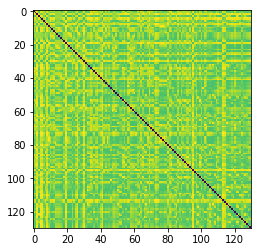

In [71]:
plt.imshow(zsim);

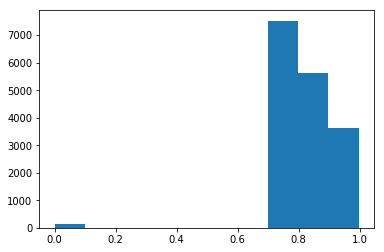

In [72]:
plt.hist(zsim.reshape(-1));

In [32]:
grpidw, zhistw = groupbins(X, y, zedges, npct=10, validate=False, weighted=True, maxiter=None)

nmin 500 nmax 50000 ndata 1000000
nfbin 1000


In [33]:
zhist.shape, zhistw.shape

((49, 100), (130, 100))

In [73]:
def plotz(zhist):
    nbin = len(zhist)
    zplot = zhist / zhist.max(axis=1, keepdims=True)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(zplot.T + 0.25 * np.arange(nbin), 'k-', alpha=0.5)
    plt.gca().axis('off')
    plt.tight_layout()

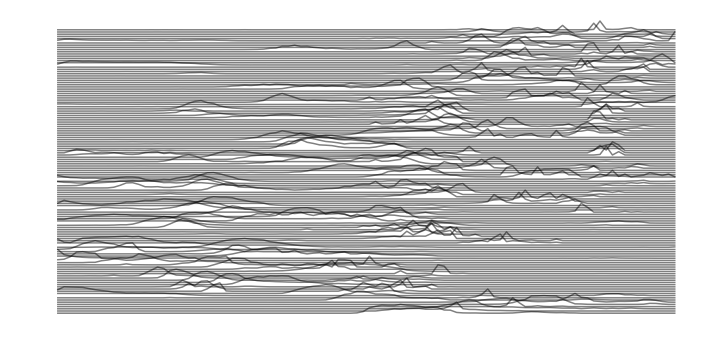

In [74]:
plotz(zhist)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


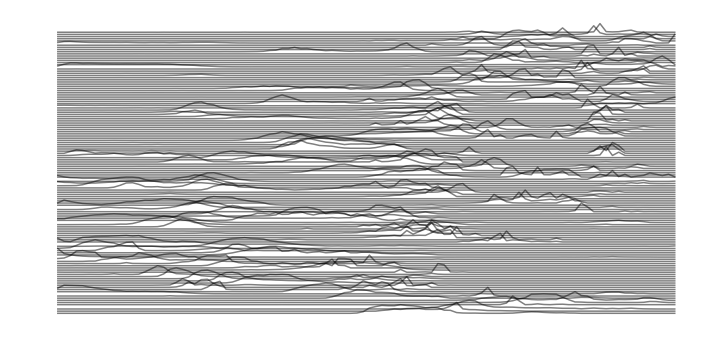

In [27]:
plotz(zhistw)

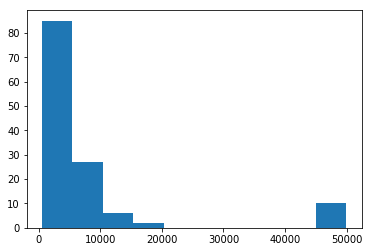

In [75]:
plt.hist(zhist.sum(axis=1));

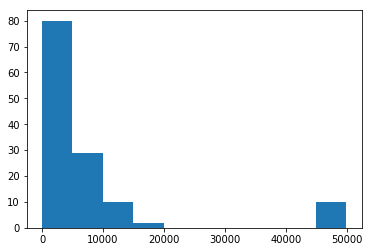

In [29]:
plt.hist(zhistw.sum(axis=1));